In [2]:
#Import des librairies
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [3]:
#Scraping de données
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('today')

df_stock = web.DataReader('AAPL', data_source='yahoo', start=start, end=end)

In [4]:
# Taille des données
print(df_stock.shape)

(2252, 6)


In [5]:
# Création de la moyenne mobile exponentielle
ema = pd.Series.ewm(df_stock['Close'], span=60).mean()
ema.values

array([ 14.6867857 ,  14.72690791,  14.79675108, ..., 116.50664807,
       116.72741364, 116.91372806])

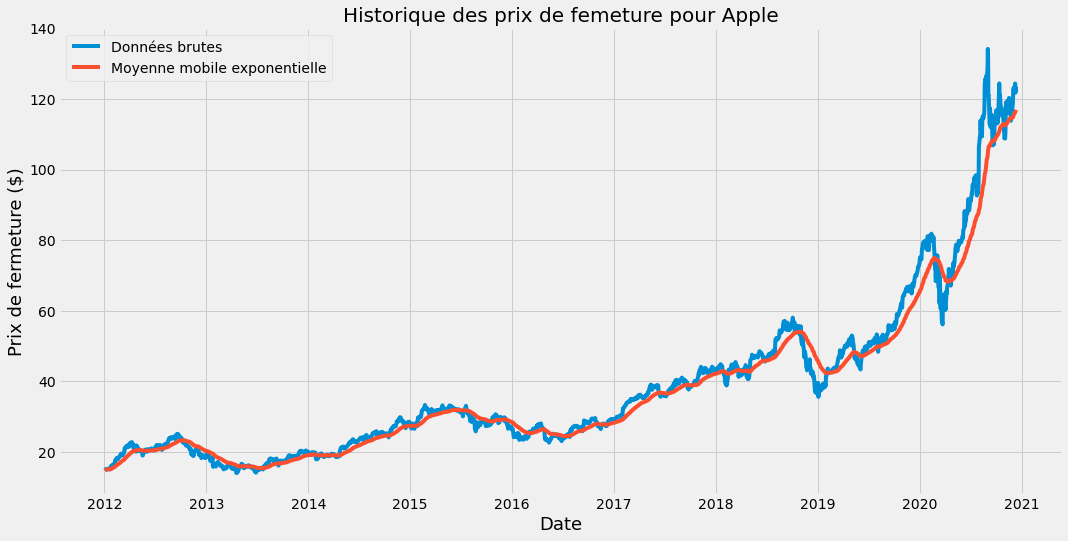

In [6]:
# Visualisation des prix de fermeture
plt.figure(figsize=(16,8))
plt.title('Historique des prix de femeture pour Apple', fontsize=20)
plt.plot(df_stock['Close'])
plt.plot(ema)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.legend(['Données brutes','Moyenne mobile exponentielle'])
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler

#On ne s'intéresse qu'aux prix de fermeture
data_stock = df_stock.filter(['Close'])

#On convertit les données en numpy array
dataset_stock = data_stock.values
dataset_ema = np.reshape(ema.values,(len(ema),1))
#Taille des données d'entraînement
training_data_len = int(len(dataset_stock) * 0.8)
training_data_len


1801

In [10]:
#Normalisation des données
scaler_stock = MinMaxScaler(feature_range=(0,1))
scaled_stock = scaler_stock.fit_transform(dataset_stock)

scaler_ema = MinMaxScaler(feature_range=(0,1))
scaled_ema = scaler_ema.fit_transform(dataset_ema)

scaled_data=np.concatenate((scaled_stock,scaled_ema),axis=1)

In [13]:
dataset_stock.shape

(2252, 1)

In [8]:
#Création des données d'entraînement
train_data = scaled_data[0:training_data_len, :]
#Création de X_train and y_train
X_train_stock = []
X_train_ema = []
y_train = []

for k in range(60,len(train_data)):
    X_train_stock.append(train_data[k-60:k,0])
    X_train_ema.append(train_data[k-60:k,1])
    y_train.append(train_data[k,0])


In [9]:
#On met les données d'entraînement en numpy array
X_train_stock, X_train_ema, y_train = np.array(X_train_stock), np.array(X_train_ema), np.array(y_train)


In [10]:
#Les données doivent être tridimensionnelles pour notre modèle
X_train_stock = np.reshape(X_train_stock, (X_train_stock.shape[0],X_train_stock.shape[1],1))
X_train_ema = np.reshape(X_train_ema, (X_train_ema.shape[0],X_train_ema.shape[1],1))
X_train = np.concatenate((X_train_stock,X_train_ema),axis=2)

In [11]:
#Modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
#Compilation
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
#Entraînement
model.fit(X_train,y_train, batch_size=3, epochs=20)


Epoch 1/20
580/580 [==============================] - 40s 68ms/step - loss: 3.9101e-04
Epoch 2/20
580/580 [==============================] - 36s 62ms/step - loss: 1.1715e-04
Epoch 3/20
580/580 [==============================] - 34s 58ms/step - loss: 1.0665e-04
Epoch 4/20
580/580 [==============================] - 36s 62ms/step - loss: 9.7741e-05
Epoch 5/20
580/580 [==============================] - 40s 69ms/step - loss: 8.0803e-05
Epoch 6/20
580/580 [==============================] - 40s 68ms/step - loss: 6.4132e-05
Epoch 7/20
580/580 [==============================] - 30s 52ms/step - loss: 6.2791e-05
Epoch 8/20
580/580 [==============================] - 37s 63ms/step - loss: 4.0468e-05
Epoch 9/20
580/580 [==============================] - 36s 62ms/step - loss: 5.4812e-05
Epoch 10/20
580/580 [==============================] - 34s 58ms/step - loss: 4.6971e-05
Epoch 11/20
580/580 [==============================] - 35s 61ms/step - loss: 4.4829e-05
Epoch 12/20
580/580 [====================

In [14]:
#Création des données de test
test_data = scaled_data[training_data_len - 60: , :]
#Création de X_test et y_test
X_test_stock=[]
X_test_ema=[]
y_test = []
y_naif = []

for k in range(60,len(test_data)):
    X_test_stock.append(test_data[k-60:k,0])
    X_test_ema.append(test_data[k-60:k,0])
    y_test.append(test_data[k,0])
    y_naif.append(test_data[k-1,0])

In [15]:
#On met les données d'entraînement en numpy array
X_test_stock, X_test_ema = np.array(X_test_stock), np.array(X_test_ema) 
y_test, y_naif = np.array(y_test), np.array(y_naif)

In [16]:
#Les données doivent être tridimensionnelles pour notre modèle
X_test_stock = np.reshape(X_test_stock, (X_test_stock.shape[0],X_test_stock.shape[1],1))
X_test_ema = np.reshape(X_test_ema, (X_test_ema.shape[0],X_test_ema.shape[1],1))
X_test = np.concatenate((X_test_stock,X_test_ema),axis=2)

In [17]:
#Prédiction
prediction_scaled = model.predict(X_test)

prediction = scaler_stock.inverse_transform(prediction_scaled)

In [18]:
#Baseline
rmse = np.sqrt(np.mean(y_naif- y_test)**2)
rmse

0.0014744622318708335

In [19]:
#Calcul de l'erreur
prediction_scaled2 = np.reshape(prediction_scaled,y_test.shape)
rmse = np.sqrt(np.mean(prediction_scaled2 - y_test)**2)
rmse

0.0030514890546755667

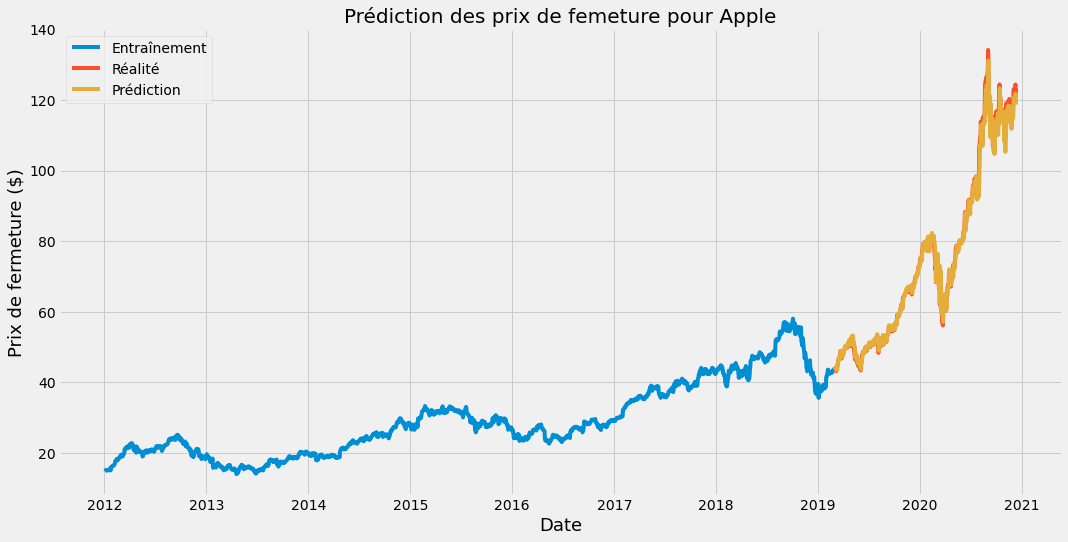

In [20]:
#Visualisation des résultats
train = data_stock[:training_data_len]
test = data_stock[training_data_len:].copy()
test['Prediction']=prediction


plt.figure(figsize=(16,8))
plt.title('Prédiction des prix de femeture pour Apple', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close','Prediction']])
plt.legend(['Entraînement','Réalité','Prédiction'])
plt.show()

In [21]:
#Montée - Descente

delta_reel = []
delta_prediction = []

for k in range (len(y_test)-1):
    delta_reel.append(y_test[k+1] - y_test[k])
    delta_prediction.append(prediction_scaled2[k+1] - y_test[k])

In [22]:
#Evaluation de la prédiction de Montée - Descente
c=0
for k in range (len(delta_reel)):
    if delta_reel[k]*delta_prediction[k] > 0:
        c+=1
        
c/len(delta_reel)

0.5466666666666666